In [1]:
# Allow to import without installing
import sys
sys.path.insert(0, "..")

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

# How to build a GeoDataFrame

We firstly explore how to do this by using the GeoJSON schema.

- See https://gist.github.com/sgillies/2217756 for the "`__geo_interface__`".
- But this basically copies GeoJSON, for which see https://tools.ietf.org/html/rfc7946

It's then as simple as this...

In [2]:
point_features = [{"geometry": {
               "type": "Point",
               "coordinates": [102.0, 0.5]
            },
           "properties": {
               "prop0": "value0", "prop1": "value1"
           }
       }]

point_data = gpd.GeoDataFrame.from_features(point_features)
point_data

,geometry,prop0,prop1
0,POINT (102 0.5),value0,value1


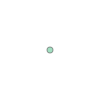

In [3]:
point_data.ix[0].geometry

In [4]:
line_features = [{"geometry": {
               "type": "LineString",
               "coordinates": [[102.0, 0.5], [104, 3], [103, 2]]
           },
           "properties": {
               "prop3": "value3"
           }
       }]

line_data = gpd.GeoDataFrame.from_features(line_features)
line_data

,geometry,prop3
0,"LINESTRING (102 0.5, 104 3, 103 2)",value3


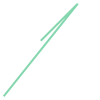

In [5]:
line_data.ix[0].geometry

In [6]:
polygon_features = [{"geometry": {
               "type": "Polygon",
               "coordinates": [[[102.0, 0.5], [104, 3], [102, 2], [102,0.5]]]
           },
           "properties": {
               "prop4": "value4", "prop1": "value1"
           }
       }]

data = gpd.GeoDataFrame.from_features(polygon_features)
data

,geometry,prop1,prop4
0,"POLYGON ((102 0.5, 104 3, 102 2, 102 0.5))",value1,value4


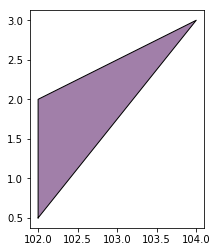

In [7]:
data.plot()

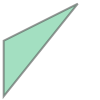

In [8]:
data.ix[0].geometry

In [9]:
features = []
features.extend(point_features)
features.extend(line_features)
features.extend(polygon_features)
gpd.GeoDataFrame.from_features(features)

,geometry,prop0,prop1,prop3,prop4
0,POINT (102 0.5),value0,value1,NaN,NaN
1,"LINESTRING (102 0.5, 104 3, 103 2)",NaN,NaN,value3,NaN
2,"POLYGON ((102 0.5, 104 3, 102 2, 102 0.5))",NaN,value1,NaN,value4


## Notes

Some things that jumped out at me as I read the GeoJSON spec:

- Coordinates are always in the order: longitude, latitude.
- A "Polygon" is allowed to contain holes.  The "outer" edge should be ordered counter-clockwise, and each "inner" edge (i.e. a "hole") should be clockwise.
- If a polygon contains more than one array of points, then the first array is the outer edge, and the rest inner edges.
- Lines crossing the anti-meridian need to be split.  (I wonder what OSM does?)

# Via using `shapely`

Under the hood, geopandas uses the `shapely` library, and we can alternatively build data frames by directly building `shapely` objects

In [10]:
type(point_data.geometry[0]), type(line_data.geometry[0]), type(data.geometry[0])

(shapely.geometry.point.Point,
 shapely.geometry.linestring.LineString,
 shapely.geometry.polygon.Polygon)

In [11]:
import shapely.geometry

In [12]:
pts = shapely.geometry.LineString([shapely.geometry.Point(0,0), shapely.geometry.Point(1,0), shapely.geometry.Point(1,1)])
df = gpd.GeoDataFrame({"geometry": [pts], "key1":["value1"], "key2":["value2"]})
df

,geometry,key1,key2
0,"LINESTRING (0 0, 1 0, 1 1)",value1,value2


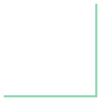

In [13]:
df.ix[0].geometry

# Support in the library

In [14]:
import osmdigest.geometry as geometry
import osmdigest.sqlite as sq

import os
filename = os.path.join("..", "..", "..", "Data", "california-latest.db")

In [15]:
db = sq.OSM_SQLite(filename)
way = db.complete_way(33088737)
series = geometry.geoseries_from_way(way)
series

geometry    LINESTRING (-122.244191 37.819027, -122.244287...
osm_id                                               33088737
dtype: object

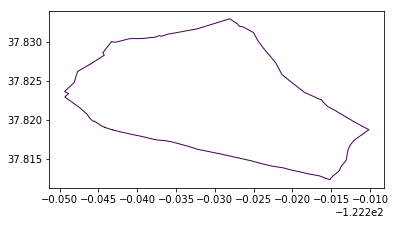

In [16]:
gpd.GeoDataFrame(series).T.plot()

In [17]:
way = db.complete_way(285549437)
series = geometry.geoseries_from_way(way)
series

addr:city                                                    Piedmont
addr:housenumber                                                  344
addr:postcode                                                   94611
addr:street                                           Highland Avenue
amenity                                                          bank
building                                                          yes
geometry            LINESTRING (-122.2314666 37.8246631, -122.2313...
name                                                      Wells Fargo
osm_id                                                      285549437
dtype: object

In [18]:
df = gpd.GeoDataFrame(series).T
df

,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,geometry,name,osm_id
0,Piedmont,344,94611,Highland Avenue,bank,yes,"LINESTRING (-122.2314666 37.8246631, -122.2313...",Wells Fargo,285549437


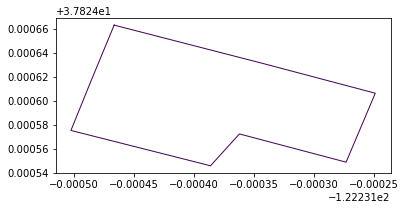

In [19]:
df.plot()

# For relations

We can build a geo data frame with the raw data from a relation.

In [20]:
relation = db.complete_relation(2866485)
geometry.geodataframe_from_relation(relation)

,barrier,geometry,members,name,note,osm_id,place,population,role,source,wikidata,wikipedia
0,NaN,None,"[(node, 2155598516, admin_centre), (node, 2155...",Palm Springs,"Areas listed as city by county, not city's sph...",2866485,city,44552,NaN,RCTLMA_GIS,Q488004,"en:Palm Springs, California"
1,NaN,POINT (-116.540303 33.8246269),NaN,Palm Springs,NaN,2155598516,city,44552,admin_centre,Wikipedia,NaN,"en:Palm Springs, California"
2,NaN,POINT (-116.540303 33.8246269),NaN,Palm Springs,NaN,2155598516,city,44552,label,Wikipedia,NaN,"en:Palm Springs, California"
3,NaN,"LINESTRING (-116.4771365 33.7724258, -116.4755...",NaN,NaN,NaN,301016136,NaN,NaN,outer,NaN,NaN,NaN
4,NaN,"LINESTRING (-116.4776487 33.7724256, -116.4771...",NaN,NaN,NaN,301016103,NaN,NaN,outer,NaN,NaN,NaN
5,NaN,"LINESTRING (-116.4776496 33.7721148, -116.4776...",NaN,NaN,NaN,301016104,NaN,NaN,outer,NaN,NaN,NaN
6,NaN,"LINESTRING (-116.4779212 33.7710789, -116.4778...",NaN,NaN,NaN,301016134,NaN,NaN,outer,NaN,NaN,NaN
7,NaN,"LINESTRING (-116.4782632 33.7705517, -116.4780...",NaN,NaN,NaN,301016125,NaN,NaN,outer,NaN,NaN,NaN
8,NaN,"LINESTRING (-116.4801208 33.7667125, -116.4784...",NaN,NaN,NaN,301016128,NaN,NaN,outer,NaN,NaN,NaN
9,NaN,"LINESTRING (-116.480614 33.7656544, -116.48012...",NaN,NaN,NaN,301016110,NaN,NaN,outer,NaN,NaN,NaN


In [21]:
geometry.geodataframe_from_relation( db.complete_relation(63222) )

,bridge,colour,electrified,frequency,from,gauge,geometry,layer,members,name,...,osm_id,railway,ref,role,route,route_master,to,tunnel,type,voltage
0,NaN,#FAA635,contact_line,0,NaN,1435,None,NaN,"[(relation, 2877693, ), (relation, 3433311, )]",J-Church,...,63222,light_rail,J,NaN,NaN,light_rail,NaN,NaN,route_master,600
1,NaN,#FAA635,NaN,NaN,Balboa Park Station,NaN,None,NaN,"[(way, 247320917, ), (way, 159785611, ), (way,...",J-Church: Inbound to Downtown,...,2877693,NaN,J,,light_rail,NaN,Embarcadero Station,NaN,route,NaN
2,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.446833 37.7209604, -122.44679...",NaN,NaN,Muni Metro,...,247320917,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600
3,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4458288 37.7219202, -122.4457...",NaN,NaN,Muni J,...,159785611,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600
4,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4446761 37.7230291, -122.4443...",NaN,NaN,Muni J,...,159791118,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600
5,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4385522 37.7298607, -122.4384...",NaN,NaN,Muni J,...,160279679,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600
6,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4353891 37.7311316, -122.4351...",-1,NaN,Muni J,...,309010742,light_rail,NaN,,NaN,NaN,NaN,yes,NaN,600
7,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4350813 37.7316453, -122.4350...",NaN,NaN,Muni J,...,309010734,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600
8,yes,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4326384 37.7329369, -122.4320...",2,NaN,Muni J,...,159798877,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600
9,NaN,NaN,contact_line,0,NaN,1435,"LINESTRING (-122.4320284 37.7332331, -122.4312...",NaN,NaN,Muni J,...,160268072,light_rail,NaN,,NaN,NaN,NaN,NaN,NaN,600


# Looking at relations

These are harder to compute automatically, because the exact interpretation of the sub-elements depends upon context.  However, most relations which have "interesting" geometry (as opposed to giving contextual information on other elements) are of ["multi-polygon" type](http://wiki.openstreetmap.org/wiki/Relation:multipolygon), and can be recognised by the presence of ways with the "role" of "inner" or "outer".

I found that using the `shapely` library itself was the easiest way to conver the geometry.

There are some cases of geometry which shapely cannot handle.  For example:
- http://www.openstreetmap.org/relation/70986  (A lot of self-intersection, I think).
- http://www.openstreetmap.org/relation/184199  (Ditto).
- http://www.openstreetmap.org/relation/1483140  (Adjoining polygons).

In [264]:
gen = db.relations()
for _ in range(15):
    next(gen)

relation = next(gen)
print(relation)
series = geometry.geoseries_from_relation(db.complete_relation(relation))
series

Relation(22601 ->  [Member(type='way', ref=25774607, role='outer'), Member(type='way', ref=25790915, role='inner')] {'name': 'Charles W. Davidson College of Engineering', 'type': 'multipolygon', 'source': 'survey', 'website': 'http://www.engr.sjsu.edu/', 'building': 'university'})


building                                           university
geometry    POLYGON ((-121.8819651 37.3363975, -121.881993...
name               Charles W. Davidson College of Engineering
osm_id                                                  22601
source                                                 survey
type                                             multipolygon
website                             http://www.engr.sjsu.edu/
dtype: object

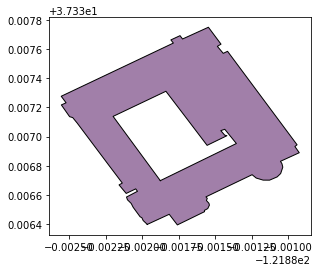

In [265]:
gpd.GeoDataFrame(series).T.plot()